# Jupyter Example 6 for HERMES: Dark Matter

In [1]:
from pyhermes import *
from pyhermes.units import GeV, kpc, pc, deg, erg, sun_mass

import numpy as np
import healpy
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
gamma_slope = 1.2
concentration = 18
M_200 = 0.7 * 8e11 * sun_mass

dmProfile = darkmatter.NFWGProfile(gamma_slope, concentration, M_200)
dmSpectrum = darkmatter.PPPC4DMIDSpectrum(darkmatter.Channel.b, darkmatter.Mass.m100GeV)

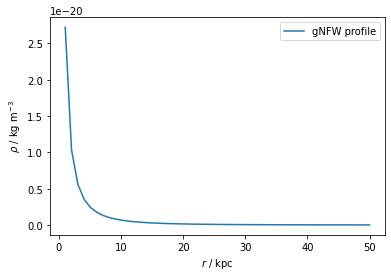

In [3]:
r_range = np.linspace(0,50)*kpc
profile_range = [dmProfile.getMassDensity(r) for r in r_range]
plt.plot(r_range/kpc, profile_range, label="gNFW profile")
plt.xlabel(r"$r$ / kpc")
plt.ylabel(r"$\rho$ / $\mathrm{kg\ m^{-3}}$")
plt.legend()

In [4]:
E_gamma_range = np.logspace(-2,2,100)*GeV

integrator = DarkMatterIntegrator(dmSpectrum, dmProfile)

sun_pos = Vector3QLength(8.0*kpc, 0*pc, 0*pc)
integrator.setSunPosition(sun_pos)

nside = 256
skymap_range = GammaSkymapRange(nside, 1e-2*GeV, 100*GeV, 20)
skymap_range.setIntegrator(integrator)

mask = RectangularWindow(latitude=[5*deg, -5*deg],
                         longitude=[-5*deg, 5*deg])
skymap_range.setMask(mask)
    
skymap_range.compute()

In [5]:
#use_units = skymap_range.getUnits() # default units for GammaSkymap (GeV^-1 m^-2 s^-1 sr^-1)
use_units = "GeV^-1 cm^-2 s^-1 sr^-1" # override default
skymap_units = u.Quantity(1, use_units)
base_units = skymap_units.unit.si.scale

In [6]:
def calc_mean_flux(skymap_range):
    energies = np.array([float(s.getEnergy()/GeV) for s in skymap_range])
    fluxes = np.array([s.getMean() for s in skymap_range]) / base_units
    return energies, fluxes

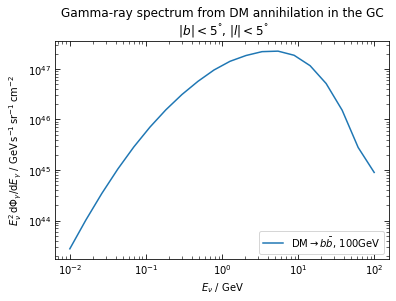

In [7]:
def plot_spectrum(skymap_range, label, style):
    energies, fluxes = calc_mean_flux(skymap_range)
    plt.plot(energies, fluxes*energies**2, style, label=label)
    
def plot_total_spectrum(list_of_skymap_range, label, style):
    fluxes = QDifferentialIntensity(0)
    for skymap_range in list_of_skymap_range:
        energies, fluxes_i = calc_mean_flux(skymap_range)
        fluxes = fluxes + fluxes_i
    plt.plot(energies, fluxes*energies**2, style, label=label)

fig, ax = plt.subplots()

plot_spectrum(skymap_range, r'$\mathrm{DM} \rightarrow b\bar{b}$, $100 \mathrm{GeV}$', '-')

plt.title("Gamma-ray spectrum from DM annihilation in the GC\n $|b| < 5^\degree$, $|l| < 5^\degree$")

plt.xlabel(r"$E_\nu$ / GeV")
plt.ylabel(r"$E_\nu^2\, \mathrm{d}\Phi_\gamma / \mathrm{d} E_\gamma$ / " + (skymap_units*u.GeV**2).unit.to_string(format='latex_inline'))

ax.tick_params(which='minor', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=3)
ax.tick_params(which='major', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=5)
plt.xscale("log")
plt.yscale("log")

plt.legend(loc="lower right")

#plt.savefig("img/darkmatter-gr-diffuse-emission-spectrum-GC.pdf", dpi=150)